In [1]:
import os
current_dir = os.getcwd()

rootpath = os.path.abspath(os.path.join(current_dir, os.pardir))

## Generate a Random Sample of Test Set + 9 Training sample

In [2]:
import pandas as pd
import random



dataset=pd.read_csv(rootpath + '/data/input_sample_data.csv',sep=";")



index_lst = range(len(dataset))
random.shuffle(index_lst)

n_sample = 200
indx_sample_lst = [index_lst[i:i + n_sample] for i in xrange(0, len(index_lst), n_sample)]


for i,indx_sample in enumerate(indx_sample_lst):
    if i==0:
        dataset.iloc[indx_sample].to_pickle(rootpath  + "/data/interim/test_sample.p")
    else:
        dataset.iloc[indx_sample].to_pickle(rootpath  + "/data/interim/train_sample_" + str(i) + ".p")

    
        


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, \
    classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize, OneHotEncoder, LabelEncoder
from datetime import date, timedelta, datetime



from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

import time
import pickle
import glob 


## Function that performs the preprocessing of the Data

In [4]:


def data_preprocessing(dataset):

    dataset["birthday"] = pd.to_datetime(dataset["birthday"])
    dataset["age"] = (date.today() - dataset["birthday"]) / timedelta(days=365.2425)

    #Should we keep imputation by zero ?
    dataset["age"] = dataset["age"].fillna(dataset["age"].mean())


    dataset["gender"] = 1*(dataset["gender"]=="F")




    maxpath = dataset['avg_total_path_days'].max()
    dataset["avg_total_path_days"] = dataset["avg_total_path_days"].map(lambda x: x / maxpath)

    print("---Total Days normalized----")

    maxsteps = dataset['no_of_steps'].max()
    dataset["no_of_steps"] = dataset["no_of_steps"].map(lambda x: x / maxsteps)

    print("---No of Steps normalized----")


    quality = {'A-Kunden':1,  'B-Kunden':2, 'C-Kunden':3}
    dataset['kundenqualitaet'] = dataset['kundenqualitaet'].map(quality).fillna(0)

    print("---Kundenquality normalized----")

    haushold = {'MANN':1,  'FRAU':2, 'FAMK':3, 'UNBE':4, 'MAFR':5, 'MPHH':6, '':7}
    dataset['haushaltsstruktur'] =  dataset['haushaltsstruktur'].map(haushold).fillna(0)


    print("---Household normalized----")

    dataset['transaction_id'] = dataset['transaction_id'].fillna(0)
    #print(dataset['transaction_id'])
    #pd.options.mode.chained_assignment = None  # default='warn'

    dataset['transaction_id'] = np.where(dataset['transaction_id'] ==  0 , 0, 1)

    print("---Transactions normalized----")

    steps = {'mail':1,  'outbound':2, 'inbound':3}
    dataset['step1'] =  dataset['step1'].map(steps).fillna(0)
    dataset['step2'] =  dataset['step2'].map(steps).fillna(0)
    dataset['step3'] =  dataset['step3'].map(steps).fillna(0)
    dataset['step4'] =  dataset['step4'].map(steps).fillna(0)
    dataset['step5'] =  dataset['step5'].map(steps).fillna(0)

    return dataset


In [5]:







#Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD Logistic': SGDClassifier(loss="log", n_iter=10000),
    'SGD Modifier Huber': SGDClassifier(loss="modified_huber", n_iter=10000),
    'SGD SVM': SGDClassifier(n_iter=10000),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier()
}





total_vect_time = 0.0
all_classes = np.array([0, 1])


train_sample_path_lst = glob.glob(rootpath  + "/data/interim/train_sample_*.p")

#initialization of the dictionary that will contain stats about the models
cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0,"AUC":[]}
    cls_stats[cls_name] = stats


        


## Read the TEST Sample 

In [6]:
#Read the test sample and perform the preprocessing
test_sample = pd.read_pickle(rootpath  + "/data/interim/test_sample.p")
test_sample = data_preprocessing(test_sample)

y_test = list(test_sample.transaction_id.values)
X_test = test_sample.drop([
    'birthday', 
    'customer_id','transaction_id'], axis=1)



---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----


## Start Point of the Chunk By Chunk

In [7]:

for i,train_sample_path in enumerate(train_sample_path_lst):

    train_sample = pd.read_pickle(train_sample_path)
    train_sample = data_preprocessing(train_sample)

    y_train = list(train_sample.transaction_id.values)
    X_train = train_sample.drop([
        'birthday', 
        'customer_id','transaction_id'], axis=1)



    tick = time.time()


    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)

        if cls_name in ['NB Multinomial','SGD Logistic','SGD Modifier Huber']:
            y_pred_prob = cls.predict_proba(X_test).transpose()[1]
            cls_stats[cls_name]['AUC'].append(roc_auc_score(y_test, y_pred_prob))
            pickle.dump( roc_curve(y_test, y_pred_prob), open( rootpath+ "/data/results/fpr_tpr_"+ cls_name +".pickle", "wb" ) )
        else:
            y_score = cls.decision_function(X_test)
            fpr,tpr,_ = roc_curve(y_test, y_score)
            cls_stats[cls_name]['AUC'].append(auc(fpr,tpr))
            pickle.dump( (fpr,tpr,_) , open( rootpath+ "/data/results/fpr_tpr_"+ cls_name +".pickle", "wb" ) )


            
        
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

    pickle.dump( cls_stats, open( rootpath+ "/data/results/dic_res_partial_fit.pickle", "wb" ) )


---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----
---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----
---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----


/Users/axa/anaconda/envs/fraud_env/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----
---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----
---Total Days normalized----
---No of Steps normalized----
---Kundenquality normalized----
---Household normalized----
---Transactions normalized----


## Plot the accuracy results by chunk

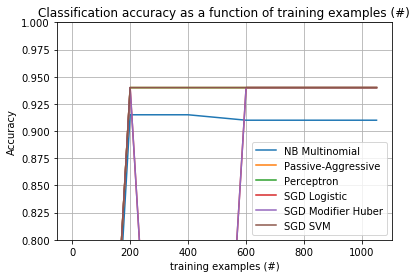

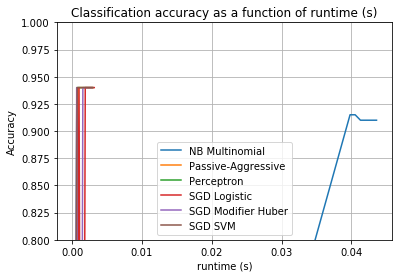

In [8]:

import pickle
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
    


cls_stats = pickle.load(  open( rootpath+ "/data/results/dic_res_partial_fit.pickle", "rb" ) )

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])



plt.show()